In [1]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline
from diffusers import utils
from diffusers import UNet2DConditionModel

from torchvision.utils import save_image
import csv
import IPython.display as ipd

import matplotlib.pyplot as plt
import PIL
import requests
import torch
from io import BytesIO
from torchvision.utils import save_image
import jsonlines
from tqdm import tqdm
import skimage
import librosa
import numpy as np
from scipy.io.wavfile import write
import argparse, os, sys, datetime, glob, importlib, csv
import numpy as np
import time
import torch
import torchvision
import pytorch_lightning as pl
from matplotlib import image
import matplotlib.gridspec as gridspec

from packaging import version
from omegaconf import OmegaConf
from torch.utils.data import random_split, DataLoader, Dataset, Subset
from functools import partial
from PIL import Image

from pytorch_lightning import seed_everything
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, LearningRateMonitor
from pytorch_lightning.utilities import rank_zero_info

sys.path.append(os.getcwd())
import torchaudio
import torchaudio.transforms as transforms
import time
from transformers import AutoTokenizer, T5EncoderModel
from encodec import EncodecModel
from encodec.utils import convert_audio

import torchaudio
import torch
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [221]:
model_path = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_path, device_map=None, safety_checker=None)
pipe.to("cuda")



Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [226]:

tokenizer = AutoTokenizer.from_pretrained("t5-small")
T5encoder = T5EncoderModel.from_pretrained("t5-small")

tokenizer.model_max_length = 77
T5encoder.to("cuda")


pipe.tokenizer = tokenizer
pipe.text_encoder = T5encoder

Some weights of the model checkpoint at t5-small were not used when initializing T5EncoderModel: ['decoder.block.5.layer.2.DenseReluDense.wi.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.3.layer.1.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.3.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.1.EncDecAttention.q.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.0.layer_norm.weight', 'decoder.block.5.layer.0.SelfAttention.q.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decod

In [216]:
conf = "/home/junchenl/data_2/alpaca_bal/checkpoint-10000/unet"
new_unet = UNet2DConditionModel.from_pretrained(conf)
new_unet.to("cuda")
pipe.unet = new_unet

512

In [227]:
prompts = ["a sin wave",
          # "singing and music and song in a room",
          # "a spectrogram of the sounds of a truck idle engine sound",
          # "sounds of a whip whipping",
          # "A mel spectrogram of the sound of Humming",
          "a dog barking, howling, bark outside together",
          "a person speaking in a room with a singer and music in the background",
           # "A mel spectrogram of the sound of Hammer",
           # "Brass music and jazz played at a cafe"
          ]


imgs = [pipe(prompt=p, width=1024, height=128, num_inference_steps=256, output_type="np").images[0] for p in prompts]


  0%|          | 0/256 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (154x512 and 768x320)

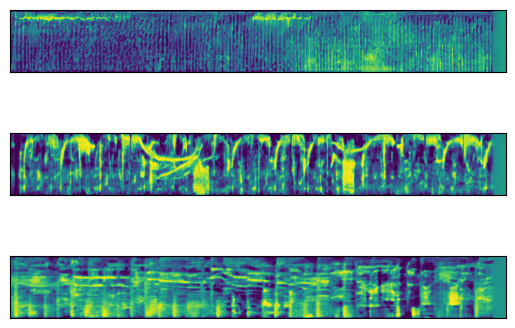

In [208]:
fig, axs = plt.subplots(len(prompts),1, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.0, 'wspace': 0.1})
for i in range(len(prompts)):
    img = imgs[i]
    np_img = np.array(img)[:,:,0]
    axs[i].imshow(np_img, cmap='viridis')
    axs[i].tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    
img = np.array(imgs[-2])

In [181]:
n_fft=1024
hop_length=160
sample_rate=22050
n_mels=128
melspec=torchaudio.transforms.MelSpectrogram(n_fft=1024,sample_rate=16000, hop_length=160, n_mels=128)
to_db=torchaudio.transforms.AmplitudeToDB()
inv_melspec=torchaudio.transforms.InverseMelScale(n_stft=n_fft//2+1,sample_rate=sample_rate)
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=n_fft,hop_length=hop_length)

def wav2fbank(waveform, db=True):
    if isinstance(waveform, str):
        waveform, sr = torchaudio.load(waveform)
    else:
        waveform = torch.Tensor(waveform)
    waveform = waveform - waveform.mean()
    #print(waveform.shape)
    fbank = melspec(waveform.squeeze())
    fbank0 = fbank.T
    if db:
        fbank=to_db(fbank)
    fbank = fbank.T
    n_frames = fbank.shape[0]
    TARGET_LEN=1024
    p = TARGET_LEN - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank, fbank0

def norm_fbank(fbank, db=True):
    if db:
        norm_mean = -10.000181
        norm_std = 15.642561
    else:
        norm_mean= -4.2677393
        norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

def unnorm_fbank(norm_fbank, db=True):
    if db:
        norm_mean = -10.000181
        norm_std = 15.642561
    else:
        norm_mean= -4.2677393
        norm_std= 4.5689974
    fbank = norm_fbank * (norm_std * 2) + norm_mean
    return fbank
def db2amp(db):
    return torch.pow(10, db/10)

def restore_wav(input_fbank):
    fbank = input_fbank[0].squeeze().T
    # un-normalize
    fbank = unnorm_fbank(fbank)
    # un-db
    fbank = db2amp(fbank)
    # inverse-melspec
    print('inv-melspec')
    stft_spec = inv_melspec(fbank)
    print('inv-melspec-finished')
    # do griffin_lim
    print('griffin_lim')
    waveform = griffin_lim(stft_spec)
    print('griffin_lim-finished')
    return waveform

def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(8, 4))
    plt.imshow(10*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    plt.axis('off')

In [182]:
fbank = img
fbank = torch.from_numpy(fbank).T
print(fbank.shape)
# plt.imshow(fbank)

torch.Size([3, 1024, 128])


In [183]:
wav = restore_wav(fbank)

inv-melspec
inv-melspec-finished
griffin_lim
griffin_lim-finished


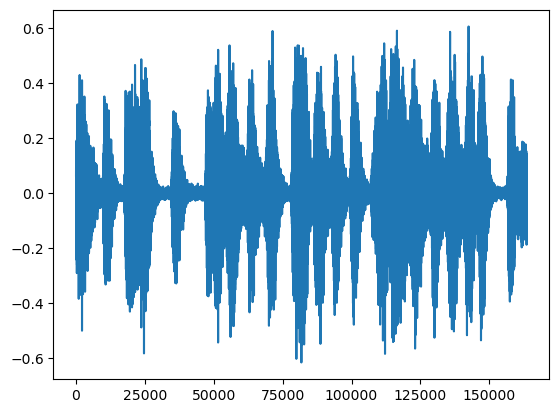

In [184]:
plt.plot(wav)

In [185]:
ipd.Audio(wav, rate=16000)


torch.Size([1, 1024, 128])


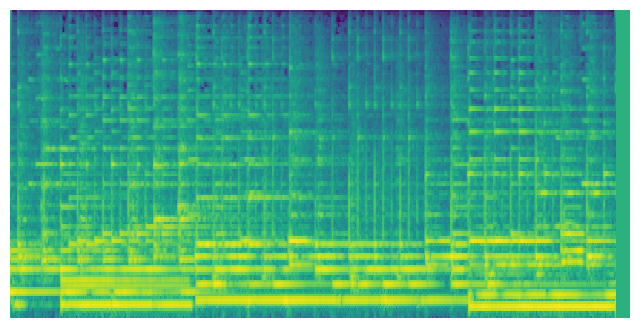

In [66]:
f_path = "C:\\Users\\Jackson\\Documents\\research\\data\\wav_files\\music.wav"

fbank, f0 = wav2fbank(f_path)
fbank = norm_fbank(fbank)
x = fbank
x = x.unsqueeze(dim=0)
# x = x.unsqueeze(dim=0)
print(x.shape)
display_fbank(x)


In [68]:
recon = restore_wav(x)

inv-melspec
inv-melspec-finished
griffin_lim
griffin_lim-finished


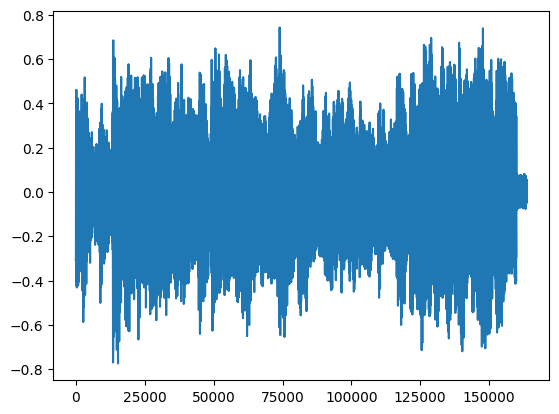

In [69]:
plt.plot(recon)
ipd.Audio(recon, rate=16000)

<class 'numpy.ndarray'>


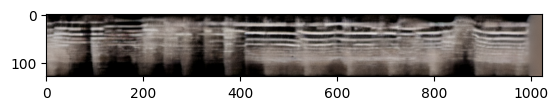

In [88]:
plt.imshow(img)
print(type(img))

tensor(0.)
tensor(0.8823)
tensor(0.3561)
tensor(0.2565)
torch.Size([1, 1024, 128])
NEW
tensor(-2.)
tensor(1.5292)
tensor(-0.5754)
tensor(1.0261)
torch.Size([1, 1024, 128])


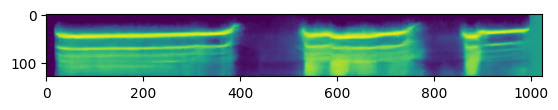

In [107]:
rescale_img = np.copy(img)
print(rescale_img.min())
print(rescale_img.max())
print(rescale_img.mean())
print(rescale_img.std())
print(rescale_img.shape)

rescale_img = rescale_img * 4
rescale_img = rescale_img - 2
print("NEW")
print(rescale_img.min())
print(rescale_img.max())
print(rescale_img.mean())
print(rescale_img.std())
print(rescale_img.shape)
plt.imshow(rescale_img.T)

In [ ]:
gen_recon = restore_wav(rescale_img)

inv-melspec


In [ ]:
plt.plot(gen_recon)
ipd.Audio(gen_recon, rate=16000)

In [70]:
from transformers import SpeechT5HifiGan, SpeechT5HifiGanConfig

# Initializing a "microsoft/speecht5_hifigan" style configuration
configuration = SpeechT5HifiGanConfig()

# Initializing a model (with random weights) from the "microsoft/speecht5_hifigan" style configuration
model = SpeechT5HifiGan(configuration)

# Accessing the model configuration
configuration = model.config

In [71]:
print(configuration)

SpeechT5HifiGanConfig {
  "initializer_range": 0.01,
  "leaky_relu_slope": 0.1,
  "model_in_dim": 80,
  "model_type": "hifigan",
  "normalize_before": true,
  "resblock_dilation_sizes": [
    [
      1,
      3,
      5
    ],
    [
      1,
      3,
      5
    ],
    [
      1,
      3,
      5
    ]
  ],
  "resblock_kernel_sizes": [
    3,
    7,
    11
  ],
  "sampling_rate": 16000,
  "transformers_version": "4.29.0.dev0",
  "upsample_initial_channel": 512,
  "upsample_kernel_sizes": [
    8,
    8,
    8,
    8
  ],
  "upsample_rates": [
    4,
    4,
    4,
    4
  ]
}



In [133]:
hi_img = torch.from_numpy(np.copy(imgs[-2]))
print(hi_img.mean())
hi_img = hi_img[:,:,0].T

low = -10
high = 10


hi_img *= (high - low)
hi_img += low
print(hi_img.mean())
print(hi_img.shape)

tensor(0.4536)
tensor(-0.4874)
torch.Size([1024, 80])


(262144,)


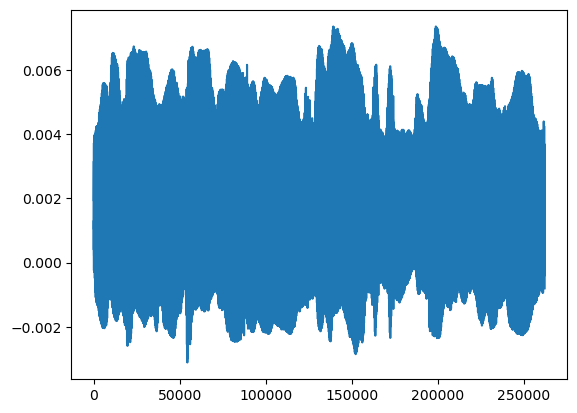

In [134]:
wav = model(hi_img)
wav = wav.detach().numpy()
plt.plot(wav)
print(wav.shape)

In [135]:
ipd.Audio(wav, rate=16000)

In [82]:


# Instantiate a pretrained EnCodec model 
model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
model.set_target_bandwidth(6.0)

In [93]:


# Load and pre-process the audio waveform
wav, sr = torchaudio.load("/home/junchenl/data_folder/AudioSet/eval_wav/-0BIyqJj9ZU.wav")
m = torch.nn.ConstantPad1d((0, 1000), 0)
wav = m(wav)
wav = wav[None, :, :]
print(wav.shape)
# wav_recon = convert_audio(wav, sr, model.sample_rate, model.channels)
# wav_recon = wav_recon.unsqueeze(0)

# Extract discrete codes from EnCodec
with torch.no_grad():
    frames = model.encode(wav)
# codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]
print(frames[0][0].shape)
print(frames[0][0].shape[2] / 8)

torch.Size([1, 1, 161000])
torch.Size([1, 8, 504])
63.0


In [94]:

recon = model.decode(frames).detach().numpy()
# print(recon.shape)

In [95]:
print(recon[0].shape)
ipd.Audio(recon[0], rate=16000)

(1, 161280)


In [96]:
ipd.Audio(wav[0], rate=16000)